# ⌚️ DM&ML 2020 - Team Rolex

## 🖋 Authors
- Francis Ruckstuhl, 16-821-738
- Hanna Birbaum, 16-050-114
- Loïc Rouiller-Monay, 16-832-453

## 🕵️ Project description

Real or Not? NLP with Disaster Tweets: Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.


## 📝 Commits

### Best commit:

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [B.] Previous commits

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [C.] Progression of accuracies

<AxesSubplot:xlabel='commit_number', ylabel='accuracy'>

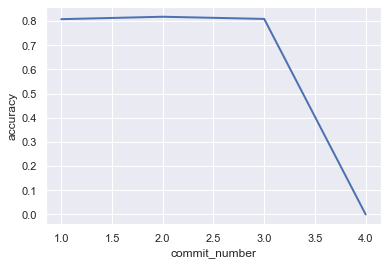

In [85]:
# /!\ You have to run Chapter 1. "libraries“ first before being able to plot the progression of accuracies
accuracy_progression = pd.read_csv('../documents/accuracy_progression.csv', sep=';')
sns.lineplot(x=accuracy_progression.commit_number, y=accuracy_progression.accuracy, linewidth=2)

# 📚 1. Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import spacy
# load English language model of spacy
sp = spacy.load('en_core_web_sm')
import string
import pycountry
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from gensim.models.doc2vec import TaggedDocument

# 📂 2. Download data


## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [133]:
train = pd.read_csv('../data/training_data.csv')
test = pd.read_csv('../data/test_data.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [134]:
train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


## Features
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


# 🔬 3. Exploratory Data Analysis

## [A.] What is the baserate of the problem?

In [136]:
base_rate = train.target.value_counts().max()/len(train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


## Target class distribution

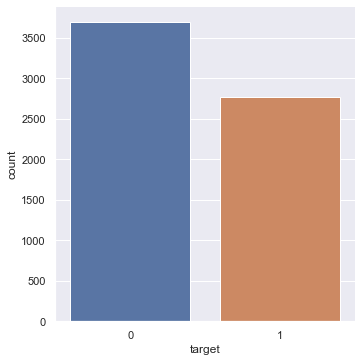

In [137]:
sns.catplot(x="target", kind="count", data=train);

## Missing values

In [138]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

It misses value in two features : keyword and location.

### Missing value in "keyword"

In [139]:
train.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

### Missing value in "location"

In [140]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

## Tweets length

### Number of characters

In [141]:
train["num_char"] = train["text"].apply(len)
test["num_char"] = test["text"].apply(len)

<AxesSubplot:xlabel='target', ylabel='num_char'>

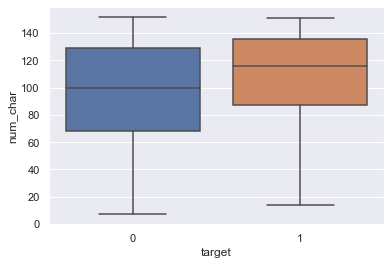

In [142]:
sns.boxplot(x='target', y='num_char', data=train)

##### Findings
Tweets about real disaster seems to be lengthier.

### Number of words

In [143]:
train["num_words"] = train["text"].apply(lambda x: len(x.split()))
test["num_words"] = test["text"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='num_words'>

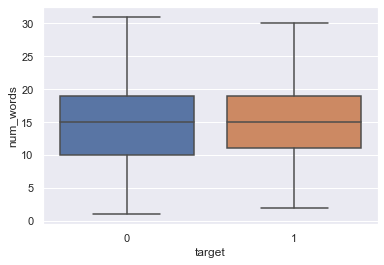

In [144]:
sns.boxplot(x='target', y='num_words', data=train)

##### Findings
Tweets about real disaster do not seem to have more words. Maybe it'll help to take this into consideration.

### Average word length

In [145]:
train["avg_word_length"] = train['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))
test["avg_word_length"] = test['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))

<AxesSubplot:xlabel='target', ylabel='avg_word_length'>

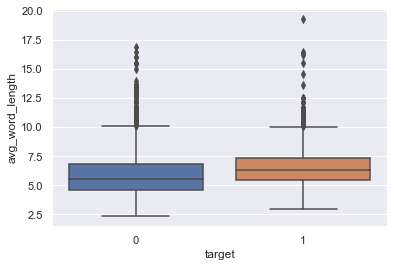

In [146]:
sns.boxplot(x='target', y='avg_word_length', data=train)

##### Findings
Tweets about real disaster seems to have lengtier average word length

### Number of hashtags in text

In [147]:
train['num_hashtags'] = train['text'].apply(lambda x: x.count('#'))
test['num_hashtags'] = test['text'].apply(lambda x: x.count('#'))

<AxesSubplot:xlabel='target', ylabel='num_hashtags'>

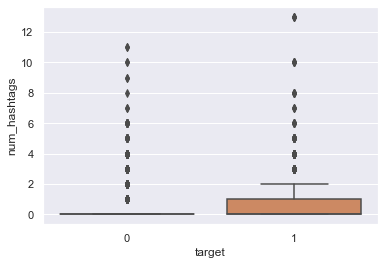

In [148]:
sns.boxplot(x='target', y='num_hashtags', data=train)

### Number of punctuation in tweets

In [149]:
punctuations = string.punctuation

def count_punctuation(text):
    count = 0
    for r in text:
        if r in punctuations:
            count += 1
    return count

In [150]:
train['num_punct'] = train['text'].apply(lambda x: count_punctuation(x))
test['num_punct'] = test['text'].apply(lambda x: count_punctuation(x))

<AxesSubplot:xlabel='target', ylabel='num_punct'>

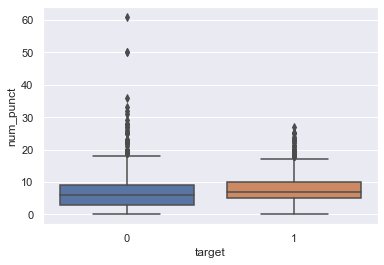

In [151]:
sns.boxplot(x='target', y='num_punct', data=train)

### Locate disasters

In [152]:
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;
# train.loc[train["target"] == 1, ["location"]].value_counts()

# 🧹 4. Data cleaning

## Keywords

In [100]:
# remove '%20' from keyword feature
train.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))
test.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))

In [101]:
# check if NaN values in the keyword feature
print(train.keyword.isnull().any())
print(test.keyword.isnull().any())

False
False


In [102]:
# use pycountry in order to check if a country appears in the location
# if yes takes the country, else turn it to NaN
# with train and test data set

In [103]:
# train.location.apply(lambda x: print(x))

## Text

In [130]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def count_punct(text):
    count = 0
    for r in text:
        if r in punctuations:
            count += 1
    return count

def separate_punct(text):
    temp = []
    for char in text:
        if char not in punctuations:
            temp.append(char)
        else:
            temp.append(' '+char)
    return ''.join(temp)

def clean_text(text):
    # remove unicode literals
    temp = text.encode('ascii',errors='ignore').decode('ascii')
    
    # remove &amp
    temp = temp.replace('&amp;', '')
    
    # remove urls
    temp = re.sub(r"http\S+", "", temp)
    
    # remove html
    temp = re.sub(r'<.*?>', "", temp)
    
    # remove hashtags
    temp = re.sub(r'#', "", temp)

    # remove people account with @
    temp = re.sub(r'@\S+', "", temp)
    
    # remove 'RT'
    # temp = temp.replace('RT', '')
    
    # remove punctuation
    # temp = ''.join([ char for char in temp if char not in punctuations ])
    
    # separate punctuation
    temp = separate_punct(temp)
    
    # remove stop words
    # temp = ''.join([ char for char in temp if char not in stop_words])
    
    # lowercase
    temp = temp.lower()
    
    return temp

In [153]:
# clean text
train.text = train.text.apply(lambda x: clean_text(x))
test.text = test.text.apply(lambda x: clean_text(x))

In [154]:
train.text.apply(lambda x: print(x))

black eye 9 : a space battle occurred at star o784 involving 3 fleets totaling 3945 ships with 17 destroyed
world fedex no longer to transport bioterror germs in wake of anthrax lab mishaps  
reality training : train falls off elevated tracks during windstorm  paramedic ems
taiwan grace : expect that large rocks trees mud unstable and /or saturated land may slide  . .very hazardous in hilly /mountain areas . . .
new isis video : isis threatens to behead croatian hostage within 48 hours  - tlvfaces  - tlvfacesauspol 
freebesieged :  .martinmj22 yougov which  'tory landslide '  . . . you can 't possibly mean the wafer -thin majority of g _ 
billionaires have a plan to free half a billion dollars trapped in venezuela for two years  reports .


 some old testimony of weapons used to promote conflicts
tactics  - corruption  infiltration of groups

ali you flew planes and ran into burning buildings why are you making soup for that man child ? ! booradleyvancullen
the thunder shook my house w

 lol more than welcome  ? ? ? ? ? ?
apparently if you 're bleeding people look at you weird lol well it 's fine keep walking
new smp ignition knock  (detonation ) sensor ks315  
3novices  : renison mine sees seismic event  a small earthquake at tasmania 's renison tin project has created a tem _
seek help warra metrofmtalk
usgs eq : m 1 .2  - 23km s of twentynine palms california : time2015 -08 -05 23 :54 :09 utc2015 -08 -05 16 : . . .  earthquake
lzk issues severe thunderstorm warning  [wind : 60 mph hail : 0 .75 in ] for sharp  [ar ] till 8 :15 pm cdt   wx
 twelve feared killed in pakistani air ambulance helicopter crash 
turn on espn2 and get blown up
 'gunman who opened fire at tennessee movie theater killed by police '  anyone suspect suicide -by -cop ?
my brains going to explode i need to leave this house . ill be out smoking packs if you need me
police unions retard justice  drain gov  $ but cops vote 4 rs so rs go after teachers unions instead !     
why does my phone electrocu

patrick roy 1998 -99 upper deck spx 171 finite 1620 made colorado avalanche mint  
jewish leaders prayed at the hospital where a palestinian family is being treated after arson  via 
oso washington mudslide response interview  part 1 
lukebox something about first responders / military they are our true hero 's ! ! besides your music
mtsalert orange  blue line riders : expect delays downtown due to a sinkhole that 's developed in the vicinity of 4th  c street .
new explosion -proof tempered glass screen protector film for blackberry z10  - full read by _  
usgs m 1 .2  - 23km s of twentynine palms california : time2015 -08 -05 23 :54 :09 utc2015 -08 -05 16 :54 :09  -07 :0 . . .  sm
photo bombed  ? ? ? ? 
320  [ir ] icemoon  [aftershock ]  |   |   | dubstep trapmusic dnb edm dance ices _ 
sitting in a cafe enjoying a bite and cramming for my meeting during my whirlwind 14 -hours in nyc ! 
roosevelt wash . under evacuation order due to wildfire 
the 8 -minute fat -burning routine thats a

 you 're another one for the history books !  (thank the justice department ! ) and by the way i haven 't paid income tax in 20yrs .
haley lu richardson fights for water in the last survivors  (review ) 
new mad max screenshots show off a lovely dust storm combat magnum opus 
japan aogashima volcano . by unknown  - check it out ! 
 aogashima japan photography volcano
check this  udhampur terror attack : militants attack police post 2 spos injured : _  suryaray india
now on  photos : flames rage through manchester buildings in 3 -alarm fire  nh1news
when houston and nyc collide .  ? ?      gemma bowe _ 
pbban  (temporary :300 ) avysss   | do not kill  | flags only  | fast xp ' for reason
myanmar  displaced rohingya at sittwe point of no return   prison like conditions genocide ihhen msf refugees
city of calgary activates municipal emergency plan  - 660 news  
runaway minion causes traffic collapse in dublin 
i agree with certain cultural appropriation things but honestly if u looked at 

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: text, Length: 6471, dtype: object

## Location

In [11]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

# 🛠 [D.] 5. Feature Engineering

In [26]:
pycountry.countries.search_fuzzy('England')

[Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')]

In [27]:
# not good 

def location_to_country(location):
    temp = location.split(',')
    countries = list(pycountry.countries)
    
    for word in temp:
        for i in range(len(countries)):
            if (word.strip() in countries[i].alpha_2) or (word.strip() in countries[i].alpha_3) or (word.strip() in countries[i].name):
                return countries[i].name
    return 'Unknown'

train['country'] = train.location.apply(lambda x: location_to_country(str(x)))
train[['location', 'country']].head(60)

,location,country
0,USA,United States
1,NaN,Unknown
2,"Palm Beach County, FL",Falkland Islands (Malvinas)
3,USA,United States
4,Australia,Australia
5,Scotland,Unknown
6,New York City,Unknown
7,Multinational *****,Unknown
8,Los Angeles,Unknown
9,NaN,Unknown


## Text

In [ ]:
train

In [ ]:
train.num_char * train.num_punct

In [ ]:
train['num_punct_mult_num_char'] = train.apply(lambda x: x.)
test['num_punct'] = test['text'].apply(lambda x: count_punctuation(x))

In [ ]:
sns.boxplot(x='target', y='num_hashtags', data=train)

# ⚙️ 6. Preprocessing

In [28]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove all word with less that 3 letters (remove noise)
    mytokens = [ word for word in mytokens if len(word)>2 ]

    # Return preprocessed list of tokens
    return mytokens

In [29]:
# Tokenize texts
processed_texts = []
for text in train.text:
    processed_text = spacy_tokenizer(text)
    processed_texts.append(processed_text)

# 🤖 7. Models

## BOW with Logistic Regression

In [155]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit_transform(train.text)

In [156]:
# Get feature names
feature_names = count.get_feature_names()

In [157]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [158]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [159]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

In [160]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000)

In [161]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7938


#### BOW with more additional features

In [162]:
train_full = pd.concat([processed_train, train[['num_char', 'avg_word_length', 'num_punct']]], axis=1)

In [163]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [164]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=3000, cv=4)

In [ ]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

In [ ]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

## TF-IDF with Logistic Regression

In [69]:
# Select features
X = train['text'] # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [82]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

CPU times: user 1min 22s, sys: 1.82 s, total: 1min 24s
Wall time: 1min 37s


/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=5, sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', LogisticRegressionCV(cv=5, max_iter=1000))])

In [83]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7776


## Decision tree

In [73]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 1min 41s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', DecisionTreeClassifier())])

In [74]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7205


## Classification using Doc2Vec and Logistic Regression

In [37]:
sample_tagged = train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

NameError: name 'spacy_tokenizer' is not defined

In [38]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

NameError: name 'sample_tagged' is not defined

In [ ]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=1, vector_size=100, negative=5, hs=0, min_count=1, sample=0, workers=cores, epoch=500)
model_dbow.build_vocab([x for x in train_tagged.values])

In [ ]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [50]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=300)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Each document (i.e. complaint) is now a vector in the space of 30 dimentions.
# Similar complaints should have similar vector representation.

In [51]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegressionCV(max_iter=3000, cv=3, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=3, max_iter=3000)

In [52]:
# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7876


## Classification using Doc2Vec, more features and Logistic Regression

# 🏆 8. Submission

## BOW

In [19]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit(train.text)
bow = count.transform(train.text)

In [20]:
# Get feature names
feature_names = count.get_feature_names()

In [21]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [22]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length', 'num_hashtags']], processed_train], axis=1)

In [23]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

In [24]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=6000, cv=3)

In [25]:
%%time
# Fit model on training set
classifier.fit(X, y)

Wall time: 1h 38min 30s


LogisticRegressionCV(cv=3, max_iter=6000)

In [30]:
bow_test = count.transform(test.text)
# Get feature names
feature_names_test = count.get_feature_names()

In [31]:
# Show as a dataframe
processed_test = pd.DataFrame(
    bow_test.todense(),
    columns=feature_names_test
    )

In [32]:
test_full = pd.concat([test[['num_char', 'num_words', 'avg_word_length' , 'num_hashtags']], processed_test], axis=1)

In [33]:
# Predictions

y_pred = classifier.predict(test_full)

## TF IDF

In [28]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

In [29]:
pipe.fit(train.text, train.target)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [30]:
preds = pipe.predict(test.text)

In [31]:
preds

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

## Export submission

In [34]:
sample_submission.target = y_pred

In [35]:
sample_submission

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [36]:
sample_submission.to_csv('submission-003.csv', index=False)